source: Yahoo Finance https://finance.yahoo.com/quote/MSFT/history?p=MSFT
<br> stock Microsoft (MSFT) from 5/6/2002 - 3/6/2022 (20years) <br>


In [13]:
#import libaries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [15]:
#Read the file
data = pd.read_csv('/content/drive/MyDrive/PTDLKD/MSFT.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-06-05,25.215000,25.875000,25.165001,25.830000,16.235571,66969400
1,2002-06-06,25.750000,26.070000,25.000000,25.950001,16.311005,78703400
2,2002-06-07,24.945000,26.299999,24.930000,25.990000,16.336136,97834400
3,2002-06-10,25.825001,26.650000,25.730000,26.410000,16.600134,71825400
4,2002-06-11,26.620001,27.090000,26.209999,26.285000,16.521574,74368200


In [16]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5031,2022-05-27,268.480011,273.339996,267.559998,273.239990,273.239990,26910800
5032,2022-05-31,272.529999,274.769989,268.929993,271.869995,271.869995,37827700
5033,2022-06-01,275.200012,277.690002,270.040009,272.420013,272.420013,25292200
5034,2022-06-02,264.450012,274.649994,261.600006,274.579987,274.579987,44008200
5035,2022-06-03,270.309998,273.450012,268.410004,270.019989,270.019989,28048000


In [17]:
len(data)

5036

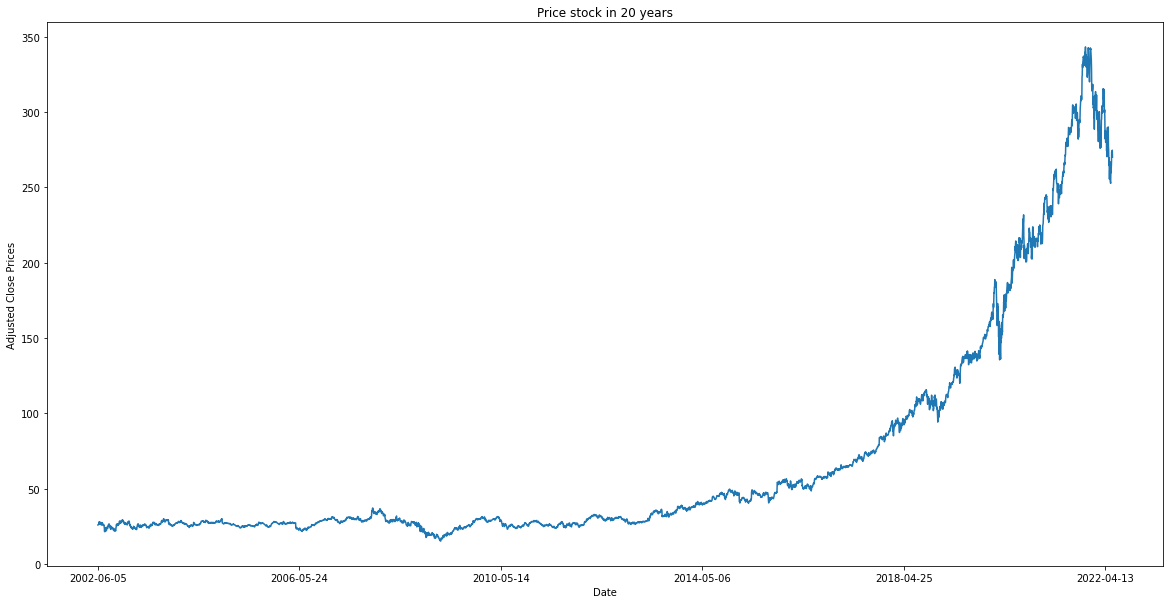

In [18]:
plt.figure(figsize=(20,10)) #Set width, height in inches
data_copy=data.copy() 
data_copy.set_index("Date", inplace=True) #Set ['Date'] as index
data_copy['Close'].plot()
plt.title('Price stock in 20 years')
plt.ylabel("Adjusted Close Prices")
plt.show()

In [19]:
df=data[['Close']]

In [20]:
df

,Close
0,25.830000
1,25.950001
2,25.990000
3,26.410000
4,26.285000
...,...
5031,273.239990
5032,271.869995
5033,272.420013
5034,274.579987


In [21]:
days_to_predict = 30 # number day want to predict(often 1w,1m,1y)
df['Prediction'] = df[['Close']].shift(periods=-days_to_predict) # add new 'Prediction'column

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df.head()

,Close,Prediction
0,25.830000,25.555000
1,25.950001,24.780001
2,25.990000,23.754999
3,26.410000,21.504999
4,26.285000,23.115000


In [24]:
#convert to numy array 
x = np.array(df['Close'])[:-days_to_predict] # convert to numpy array

In [25]:
x

array([ 25.83    ,  25.950001,  25.99    , ..., 285.299988, 286.359985,
       280.809998])

In [26]:
y = np.array(df['Prediction'])[:-days_to_predict] # convert to array

In [27]:
y

array([ 25.555   ,  24.780001,  23.754999, ..., 272.420013, 274.579987,
       270.019989])

In [28]:
# Splitting train and test data
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1, 1), y, test_size = 0.2,random_state=42)

In [30]:
# Tuning model 
grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor()
from sklearn.model_selection import RandomizedSearchCV
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 2, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 6, 'bootstrap': True}


In [31]:
# Apply model and predict
model = RandomForestRegressor(n_estimators= 50, random_state=2, min_samples_split=9, min_samples_leaf=9, max_depth=8, bootstrap=True)
model.fit(x_train, y_train)
predict = model.predict(x_test)

In [32]:
# compare train and test
pd.DataFrame(np.column_stack([predict.tolist(),x_test.tolist()]),columns=['Predict',"test"])

,Predict,test
0,34.049318,34.980000
1,54.802332,51.220001
2,29.619906,29.660000
3,26.345412,26.500000
4,99.527266,96.360001
...,...,...
997,86.843166,83.260002
998,46.469855,48.009998
999,27.845871,28.230000
1000,19.093138,19.090000


In [33]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')

errors = abs(predict - y_test) 
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.6096
Mean Squared Error: 53.0942
Root Mean Squared Error: 7.2866
(R^2) Score: 0.9904
Train Score : 99.40% and Test Score : 99.04% using Random Tree Regressor.
Accuracy: 94.67 %.


In [34]:
# Getting rows from dataset except the last "x" days
# future = df.drop(['Prediction'], 1)[:-days_to_predict]
future= df['Close']
future = future.tail(days_to_predict) # returns last 30 rows from the object based on position.
# Converting data to numpy array
future = np.array(future)

In [35]:
future

array([274.029999, 280.720001, 270.220001, 283.220001, 289.630005,
       277.519989, 284.470001, 281.779999, 289.980011, 277.350006,
       274.730011, 264.579987, 269.5     , 260.549988, 255.350006,
       261.119995, 261.5     , 266.820007, 254.080002, 253.139999,
       252.559998, 260.649994, 259.619995, 262.519989, 265.899994,
       273.23999 , 271.869995, 272.420013, 274.579987, 270.019989])

In [39]:
predictions = pd.DataFrame(future,columns=['Close'],index=pd.date_range(start=data.Date[len(data)-1], periods=len(future), freq="D"))
predictions

,Close
2022-06-03,274.029999
2022-06-04,280.720001
2022-06-05,270.220001
2022-06-06,283.220001
2022-06-07,289.630005
2022-06-08,277.519989
2022-06-09,284.470001
2022-06-10,281.779999
2022-06-11,289.980011
2022-06-12,277.350006


In [40]:
predictions

,Close
2022-06-03,274.029999
2022-06-04,280.720001
2022-06-05,270.220001
2022-06-06,283.220001
2022-06-07,289.630005
2022-06-08,277.519989
2022-06-09,284.470001
2022-06-10,281.779999
2022-06-11,289.980011
2022-06-12,277.350006
